In [1]:
# Bibliotecas utilizadas no projeto
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, auc, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, confusion_matrix, mean_squared_error,accuracy_score, precision_recall_curve
from sklearn.metrics import r2_score
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./output/refatorado_dataset.csv', index_col=0)

### Formatação de Dados (Romero)

In [3]:
df["Fluxo Escolar - Label"] = df["Fluxo Escolar - Label"].map({'Formados': 0, 'Evadidos': 1})

In [4]:
df["Cidade Aluno"] = df["Cidade Aluno"].map(lambda cidade: 1 if cidade == 'Acaraú' else 0)

In [5]:
df["Sexo"] = df["Sexo"].map({'M': 0, 'F': 1})

In [6]:
df["Previsão de Término (Letivo)"] = df["Previsão de Término (Letivo)"].map(lambda data: int(data.replace("/","")))

In [7]:
df["previsao_ultrapassada"] =  df["Previsão de Término (Letivo)"] < df["Periodo Letivo (Num)"]

In [8]:
df["previsao_ultrapassada"] = df["previsao_ultrapassada"].map({True: 1, False: 0})

Dataset Final

In [9]:
dataset_final = df[["Fluxo Escolar - Label","Cidade Aluno", "Sexo", 'Reserva vaga', "previsao_ultrapassada", 'Nível de Ensino', 'Etnia', 'Faixa Etária']]

In [10]:
dataset_final.columns

Index(['Fluxo Escolar - Label', 'Cidade Aluno', 'Sexo', 'Reserva vaga',
       'previsao_ultrapassada', 'Nível de Ensino', 'Etnia', 'Faixa Etária'],
      dtype='object')

In [11]:
b_encoder = ce.BinaryEncoder(cols=['Nível de Ensino', 'Reserva vaga', 'Etnia', 'Faixa Etária'])

In [12]:
dataset_final = b_encoder.fit_transform(dataset_final)

In [13]:
matriz_correlacao = dataset_final.corr()

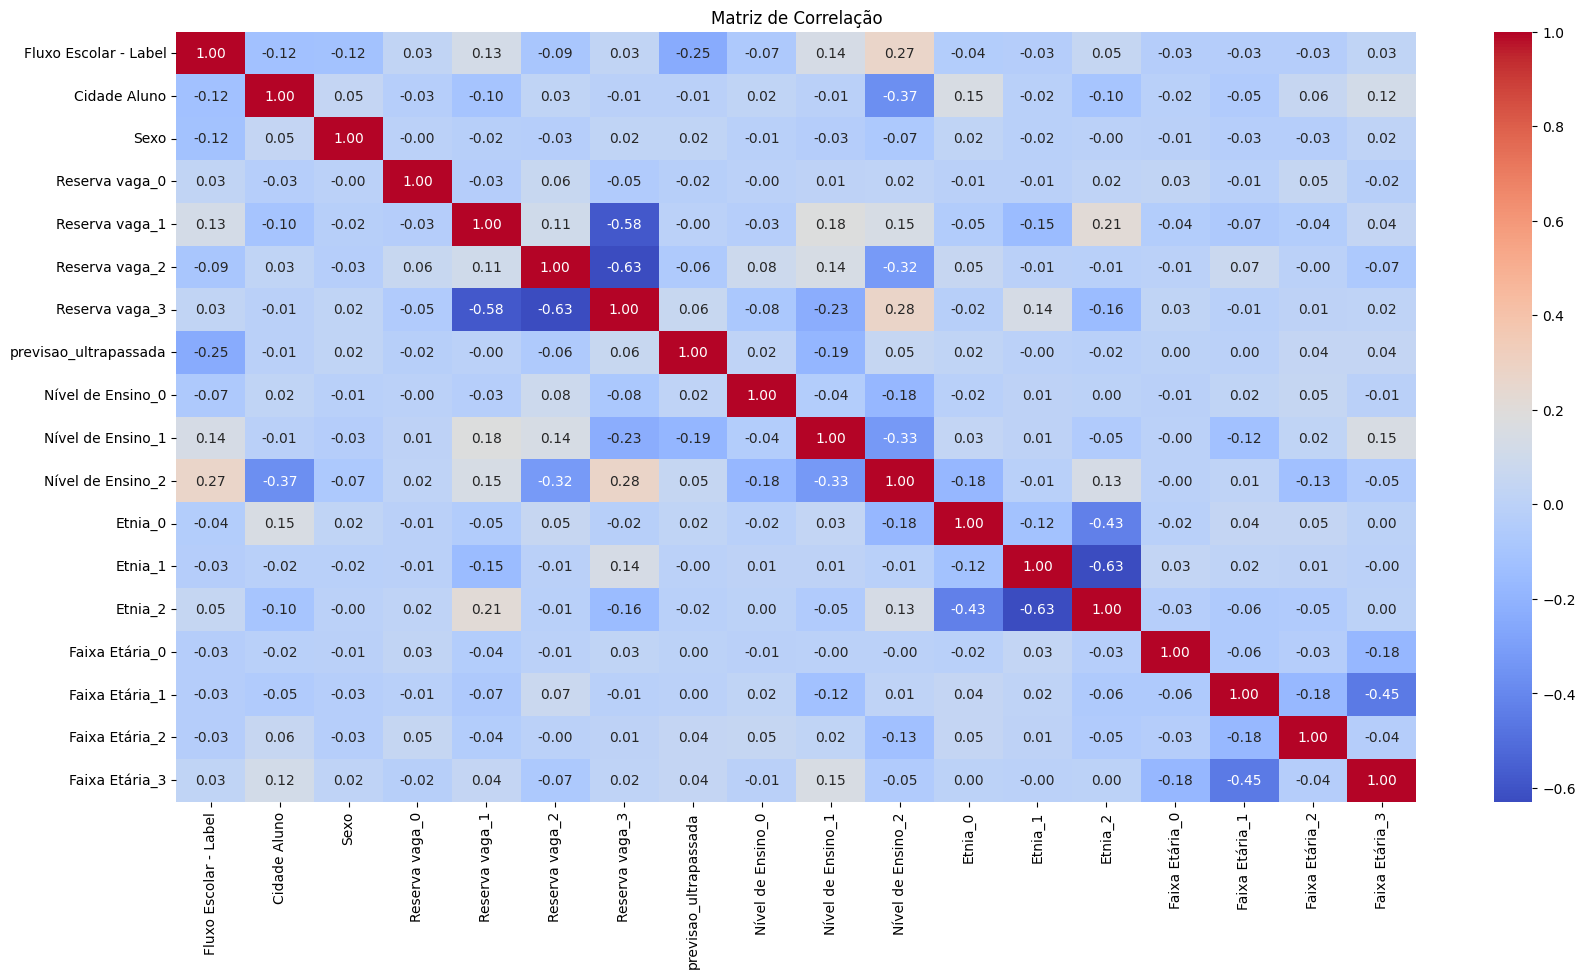

In [14]:
plt.figure(figsize=(20,10))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

In [15]:
X = dataset_final.drop('Fluxo Escolar - Label', axis=1)
y = dataset_final['Fluxo Escolar - Label']

In [16]:
# Dividir o df em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Algoritmo Random Forest

In [17]:
rf_model = RandomForestClassifier(
    n_estimators=100,          # Número de árvores na floresta
    max_depth=5,               # Profundidade máxima de cada árvore
    min_samples_split=4,       # Número mínimo de amostras necessárias para dividir um nó
    min_samples_leaf=2,        # Número mínimo de amostras que uma folha (nó terminal) deve ter
    class_weight='balanced',   # Ajusta os pesos para lidar com classes desbalanceadas
    # random_state=42            # Para reprodutibilidade
)

In [18]:
# Treinar o modelo
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=4)

In [19]:
y_pred = rf_model.predict(X_test)

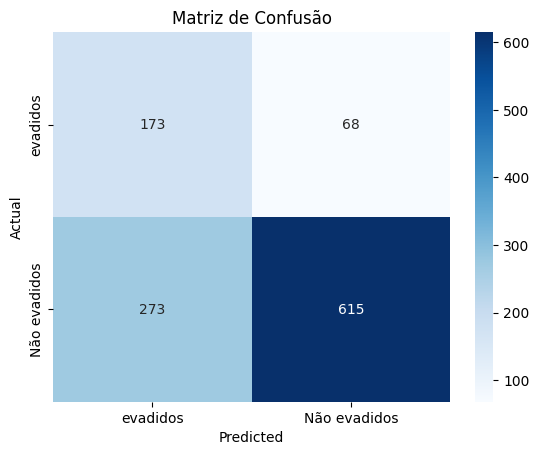

In [20]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['evadidos', 'Não evadidos'], yticklabels=['evadidos','Não evadidos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusão')
plt.show()

In [21]:
score = accuracy_score(y_test, y_pred)
score


0.6979627989371124

In [22]:
# Extraindo as importâncias das features
feature_importances = rf_model.feature_importances_

# Criando um DataFrame para organizar e visualizar
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Ordenando as features pela importância
features_df = features_df.sort_values(by='Importance', ascending=False)

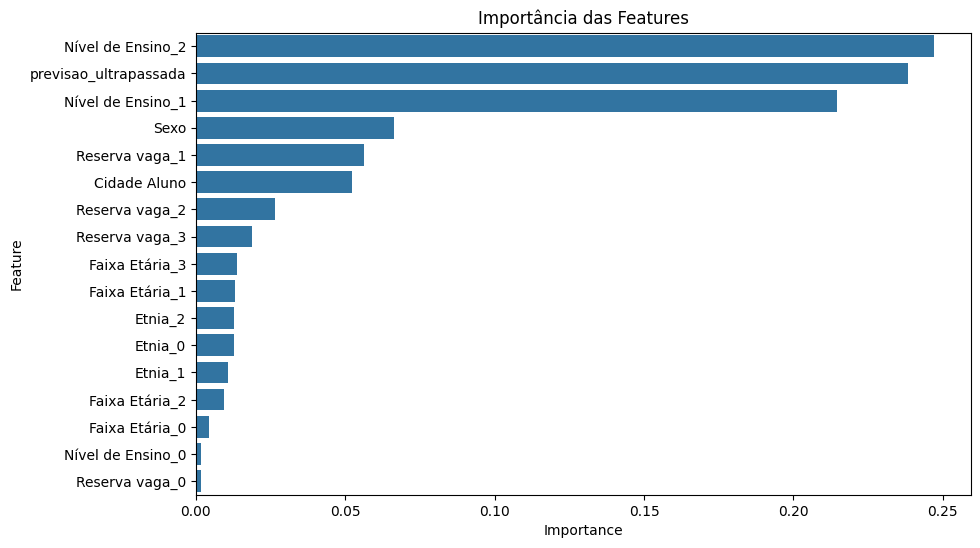

In [23]:
# Plotar as features mais importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)

plt.title('Importância das Features')
plt.show()

In [24]:
# Pegar somente os pertencentes da classe positiva

y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc_auc = roc_auc_score(y_test, y_pred_prob)

print(roc_auc)

0.805558670703899


### Curva de ROC

In [25]:
# Calculando o índice de Youden para cada limiar
#  - Objetivo é consiguir um valor de vonversão melhor
youden_j = tpr - fpr

In [26]:
best_threshold_index_argmax = np.argmax(youden_j)
best_threshold = thresholds[best_threshold_index_argmax]

print(f'Melhor limiar (threshold) com base no Youden\'s J: {best_threshold}')

# taxa de verdadeiros positivos (TPR) 
# e a taxa de falsos positivos (FPR)

Melhor limiar (threshold) com base no Youden's J: 0.5419878328566718


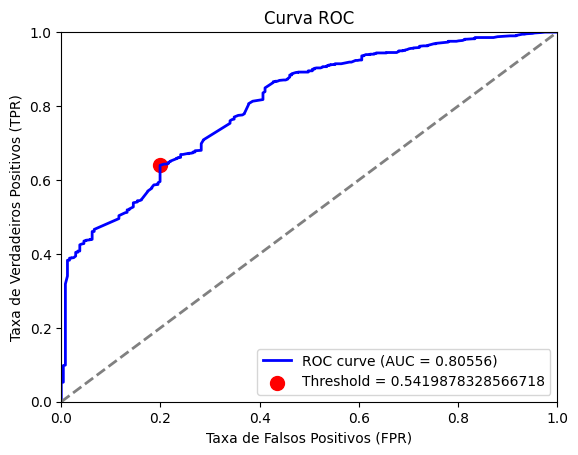

In [27]:
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Linha de referência (random guessing)

plt.scatter(fpr[best_threshold_index_argmax], tpr[best_threshold_index_argmax], color='red', s=100, label=f'Threshold = {best_threshold}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [28]:
y_pred_class = np.where(y_pred >= best_threshold, 1, 0)

# Agora você pode avaliar o desempenho com base nessas previsões

accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'Acurácia: {accuracy}')
print(f'Precisão: {precision}')
print(f'Revocação: {recall}')
print(f'F1-Score: {f1}')


Acurácia: 0.6979627989371124
Precisão: 0.9004392386530015
Revocação: 0.6925675675675675
F1-Score: 0.7829408020369192


### Precision x Recall

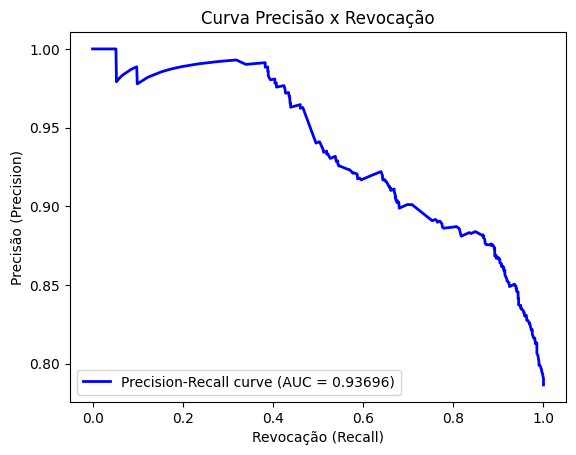

In [29]:
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred_class)

# Calculando a AUC da Curva Precision-Recall
# - Medida agregada do desempenho do modelo em diferentes limiares
precision, recall, trensholder = precision_recall_curve(y_test, y_pred_prob)

pr_auc = auc(recall, precision)

# precision, recall, _ = precision_recall_curve(y_test, y_pred_class)

# Plotando a Curva Precision-Recall
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.5f})', color='blue', lw=2)
plt.xlabel('Revocação (Recall)')
plt.ylabel('Precisão (Precision)')
plt.title('Curva Precisão x Revocação')

# Ponto de revocação x precisão que representa o meu modelo
# plt.scatter(recall, precision, color='red', s=100, label=f'Ponto específico\nPrecisão = {precision}\nRevocação = {recall}')

plt.legend(loc="lower left")
plt.show()

### Algoritmo Random Forest Regressor

In [30]:
regressor = RandomForestRegressor(
    n_estimators=100,          # Número de árvores na floresta
    max_depth=5,               # Profundidade máxima de cada árvore
    min_samples_split=4,       # Número mínimo de amostras necessárias para dividir um nó
    min_samples_leaf=2,        # Número mínimo de amostras que uma folha (nó terminal) deve ter
    # class_weigh='balanced',   # Ajusta os pesos para lidar com classes desbalanceadas
    # random_state=42            # Para reprodutibilidade
)

In [31]:
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=4)

In [32]:
# O R² mede a proporção da variância na variável dependente que é previsível a partir das variáveis independentes. É uma métrica de quão bem o modelo se ajusta aos dados.
y_pred = regressor.predict(X_test)

# (Erro Quadrático Médio)
mse = mean_squared_error(y_test, y_pred)
# accuracy = accuracy_score(y_test, y_pred)


print(f"MSE: {mse}")
# print(f"Acurácia: {accuracy}")

MSE: 0.13129074000131433


### Curva de ROC

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculando o índice de Youden para cada limiar
#  - Objetivo é consiguir um valor de vonversão melhor
youden_j = tpr - fpr

In [34]:
best_threshold_index_argmax = np.argmax(youden_j)
best_threshold = thresholds[best_threshold_index_argmax]

print(f'Melhor limiar (threshold) com base no Youden\'s J: {best_threshold}')

 # taxa de verdadeiros positivos (TPR) 
# e a taxa de falsos positivos (FPR)

roc_accuracy = roc_auc_score(y_test, y_pred)
print(f'AUC: {roc_accuracy}')

Melhor limiar (threshold) com base no Youden's J: 0.5419878328566718
AUC: 0.8004490486336958


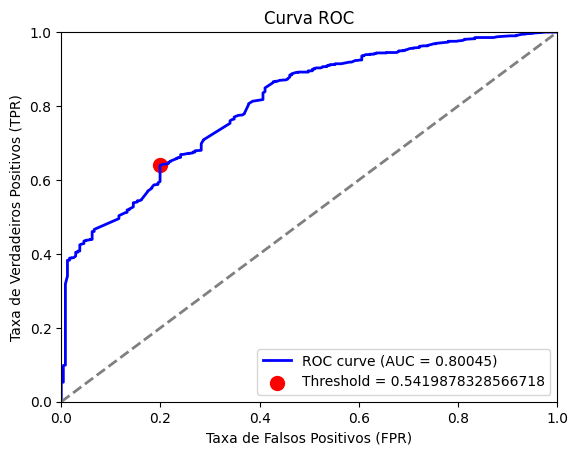

In [35]:
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_accuracy:.5f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Linha de referência (random guessing)

plt.scatter(fpr[best_threshold_index_argmax], tpr[best_threshold_index_argmax], color='red', s=100, label=f'Threshold = {best_threshold}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [36]:
y_pred_class = np.where(y_pred >= best_threshold, 1, 0)

# Agora você pode avaliar o desempenho com base nessas previsões

accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'Acurácia: {accuracy}')
print(f'Precisão: {precision}')
print(f'Revocação: {recall}')
print(f'F1-Score: {f1}')

Acurácia: 0.8157661647475642
Precisão: 0.8556485355648535
Revocação: 0.9211711711711712
F1-Score: 0.8872017353579176


### Precision x Recall

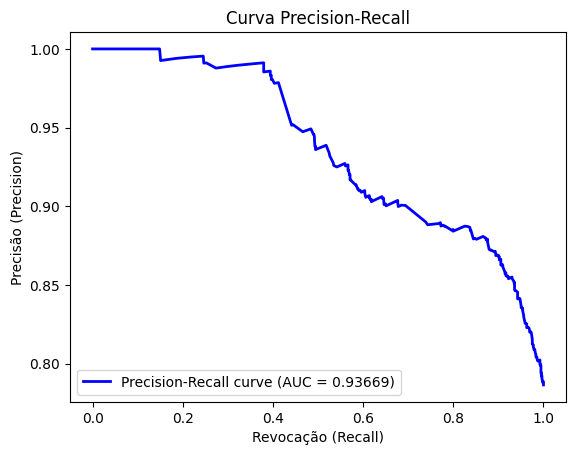

In [38]:
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred_class)

# Calculando a AUC da Curva Precision-Recall
# - Medida agregada do desempenho do modelo em diferentes limiares

precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
# precision, recall, _ = precision_recall_curve(y_test, y_pred_class)

# Plotando a Curva Precision-Recall
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.5f})', color='blue', lw=2)
plt.xlabel('Revocação (Recall)')
plt.ylabel('Precisão (Precision)')
plt.title('Curva Precision-Recall')

# Ponto de revocação x precisão que representa o meu modelo
# plt.scatter(recall, precision, color='red', s=100, label=f'Ponto específico\nPrecisão = {precision}\nRevocação = {recall}')

plt.legend(loc="lower left")
plt.show()